In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.math as tm
import numpy as np
import random
import time
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [20]:
np.random.seed(1234)
X, Y = make_moons(200, noise = 0.3)

# Split into test and training data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=73)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

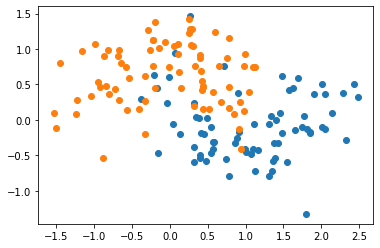

In [21]:
import matplotlib.pyplot as plt
plt.scatter(*x_train[y_train.flatten() == 1, :].T)
plt.scatter(*x_train[y_train.flatten() == 0, :].T)
plt.show()

In [22]:
type(x_train), np.shape(y_train)

(numpy.ndarray, (150, 1))

In [23]:
# Standard BP
model_bp = keras.Sequential(
    [
        keras.Input(shape=(2,)),
        layers.Dense(32, activation = "sigmoid"),
        layers.Dense(1, activation = "sigmoid")
    ]
)

batch_size = 32
epochs = 50
opt = tf.keras.optimizers.SGD(learning_rate=.1)
st = time.time()
model_bp.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", "AUC"])
history = model_bp.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

print("Time of SGD", time.time() - st)

Epoch 1/50
5/5 [==============================] - 1s 1ms/step - loss: 0.6889 - accuracy: 0.5667 - auc: 0.6154
Epoch 2/50
5/5 [==============================] - 0s 949us/step - loss: 0.6553 - accuracy: 0.6400 - auc: 0.7814
Epoch 3/50
5/5 [==============================] - 0s 1ms/step - loss: 0.6480 - accuracy: 0.6600 - auc: 0.7685
Epoch 4/50
5/5 [==============================] - 0s 1ms/step - loss: 0.6360 - accuracy: 0.7000 - auc: 0.8112
Epoch 5/50
5/5 [==============================] - 0s 1ms/step - loss: 0.6273 - accuracy: 0.7267 - auc: 0.8357
Epoch 6/50
5/5 [==============================] - 0s 1ms/step - loss: 0.6185 - accuracy: 0.7133 - auc: 0.8450
Epoch 7/50
5/5 [==============================] - 0s 1ms/step - loss: 0.6140 - accuracy: 0.7400 - auc: 0.8370
Epoch 8/50
5/5 [==============================] - 0s 1ms/step - loss: 0.6026 - accuracy: 0.7333 - auc: 0.8612
Epoch 9/50
5/5 [==============================] - 0s 1ms/step - loss: 0.5956 - accuracy: 0.7600 - auc: 0.8603
Epoch 10

dict_keys(['loss', 'accuracy', 'auc'])


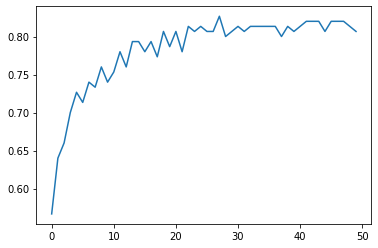

In [24]:
print(history.history.keys())
#plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

In [14]:
def convert2_zero_one(x):
    
    t = [tm.sigmoid(i) for i in x]
    
    return t

In [15]:
def rerange(x, r = 6.0):
    
    out_of_range = tf.cast(tm.greater(tm.abs(x), r), tf.float32)
    sign = tm.sign(x)
    
    return x * (1 - out_of_range) + sign * r * out_of_range

In [16]:
def cont_bern_log_norm(lam, l_lim=0.49, u_lim=0.51):
    '''
    computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    [l_lim, u_lim].
    cut_y below might appear useless, but it is important to not evaluate log_norm near 0.5 as tf.where evaluates
    both options, regardless of the value of the condition.
    '''
    
    cut_lam = tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), lam, l_lim * tf.ones_like(lam))
    log_norm = tm.log(tm.abs(2.0 * tm.atanh(1 - 2.0 * cut_lam))) - tm.log(tm.abs(1 - 2.0 * cut_lam))
    taylor = tm.log(2.0) + 4.0 / 3.0 * tm.pow(lam - 0.5, 2) + 104.0 / 45.0 * tm.pow(lam - 0.5, 4)
    return tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), log_norm, taylor)


In [17]:
# MLP model
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
    
    def call(self, x):
        
        #x = Flatten()(x)
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y):
        
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            logits = layer(pv)
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=logits)
            
            ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob

    def target_log_prob2(self, x, h, y):

        h_current = convert2_zero_one(tf.split(h, self.hidden_layer_sizes, axis = 1))
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0.
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            logits = layer(pv)
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=logits)
            
            ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_kernel, is_update_kernel = True):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = tf.concat(h_current, axis = 1)

        # run the chain (with burn-in)
        num_burnin_steps = 0
        num_results = 1

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = hmc_kernel,
            trace_fn = None,
            return_final_kernel_results = True)
    
        # Generate new states of chains
        #h_state = rerange(samples[0][0])
        h_state = samples[0][0]
        h_new = tf.split(h_state, self.hidden_layer_sizes, axis = 1) 
        
        # Update the kernel if necesssary
        if is_update_kernel:
            new_step_size = samples[2].new_step_size.numpy()
            ker_new = self.generate_hmc_kernel(x, y, new_step_size)
            return(h_new, ker_new)
        else:
            return h_new
    
    def update_weights(self, x, h, y, lr = 0.1):
        
        optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tm.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tm.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tm.greater(probs, 0.5), tf.int32)

        return labels

In [25]:
model = StochasticMLP(hidden_layer_sizes = [32], n_outputs=1)
network = [model.call(x) for x, y in train_ds]
kernels = [model.generate_hmc_kernel(x, y) for x, y in train_ds]

In [26]:
%%time

burnin = 100
for i in range(burnin):
    
    if(i % 20 == 0): print("Step %d" % i)
        
    network_new = []
    kernels_new = []
    
    res = [model.propose_new_state_hamiltonian(x, net, y, ker) 
               for (x, y), net, ker in zip(train_ds, network, kernels)]
    
    network_new, kernels_new = zip(*res)
         
    network = network_new
    kernels = kernels_new

Step 0
Step 20
Step 40
Step 60
Step 80
CPU times: user 10.9 s, sys: 33.1 ms, total: 11 s
Wall time: 10.9 s


In [27]:
epochs = 50

loss_ls = []
acc_ls = []
start_time = time.time()

for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (x, y) in enumerate(train_ds):
        
        # only one mini-batch
        model.update_weights(x, network[bs], y, 0.1)
        res = [model.propose_new_state_hamiltonian(x, net, y, ker, is_update_kernel = False) \
                   for (x, y), net, ker in zip(train_ds, network, kernels)]
        network = res
        loss += -1 * tf.reduce_mean(model.target_log_prob(x, network[bs], y))
    
    preds = [model.get_predictions(images) for images, labels in train_ds]
    train_acc = accuracy_score(np.concatenate(preds), y_train)
    loss_ls.append(loss)
    acc_ls.append(train_acc)
    
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))

print("Time of HMC: ", time.time() - start.time())

Epoch 1/50: - 0.7010s/step - loss: 225.5064 - accuracy: 0.4867
Epoch 2/50: - 0.7048s/step - loss: 224.7839 - accuracy: 0.5067
Epoch 3/50: - 0.6683s/step - loss: 224.1913 - accuracy: 0.6400
Epoch 4/50: - 0.6519s/step - loss: 224.1180 - accuracy: 0.6467
Epoch 5/50: - 0.6397s/step - loss: 223.8916 - accuracy: 0.7067
Epoch 6/50: - 0.6319s/step - loss: 223.7557 - accuracy: 0.7533
Epoch 7/50: - 0.6259s/step - loss: 223.5349 - accuracy: 0.7733
Epoch 8/50: - 0.6211s/step - loss: 223.4559 - accuracy: 0.7800
Epoch 9/50: - 0.6181s/step - loss: 223.3682 - accuracy: 0.8067
Epoch 10/50: - 0.6227s/step - loss: 223.1080 - accuracy: 0.8133
Epoch 11/50: - 0.6300s/step - loss: 223.0678 - accuracy: 0.8133
Epoch 12/50: - 0.6281s/step - loss: 223.0853 - accuracy: 0.8200
Epoch 13/50: - 0.6259s/step - loss: 223.0149 - accuracy: 0.8267
Epoch 14/50: - 0.6235s/step - loss: 222.8353 - accuracy: 0.8200
Epoch 15/50: - 0.6212s/step - loss: 222.6041 - accuracy: 0.8200
Epoch 16/50: - 0.6215s/step - loss: 222.8449 - ac

In [38]:
fig, ax = plt.subplots()

ax.plot(history.history['accuracy'], label = 'SGD')
ax.plot(list(range(epochs)), acc_ls, label = 'HMC')
ax.legend()
fig.savefig('test.png')
plt.close(fig)

In [39]:
with open('test.npy', 'wb') as f:
    np.save(f, np.array(history.history['loss']))
    np.save(f, np.array(loss_ls))

In [40]:
with open('test.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
print(a)
print(b)

[0.68886155 0.65531754 0.64796519 0.63601822 0.62729144 0.61850929
 0.61403108 0.60259217 0.5955686  0.58727962 0.58370274 0.57280195
 0.56690615 0.55869997 0.55236012 0.54682732 0.54211003 0.53354514
 0.52615088 0.52070206 0.51571268 0.50972438 0.50169265 0.49734786
 0.49358195 0.48949718 0.48219517 0.4754979  0.47144607 0.46656489
 0.46324012 0.45917505 0.45336166 0.44998142 0.44829366 0.44253591
 0.43979976 0.4379302  0.43326548 0.43174219 0.42744583 0.42364708
 0.42048156 0.41884026 0.41520405 0.41287744 0.414583   0.40829077
 0.40633067 0.40460077]
[225.50641 224.78394 224.19128 224.11801 223.89165 223.75566 223.53494
 223.45593 223.36818 223.108   223.0678  223.08534 223.01492 222.83531
 222.60413 222.84492 222.68996 222.52582 222.57217 222.41656 222.24884
 222.40184 222.35101 222.44897 222.35843 222.3799  222.30417 222.3738
 222.26898 222.23613 222.1389  221.96869 221.99731 221.8924  221.9853
 221.95499 222.01736 222.06331 221.97821 221.98276 221.73361 221.69456
 221.80635 221.9